In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd 
import numpy as np
import os
import scanpy as sc
import torch

/var/folders/n0/lbm2yq4n3r1gp83zkf5s69j00000gn/T/ipykernel_74873/2819247731.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from echidna.eval import *

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Obtain covariance tree

In [9]:
patient = 'R310'
PATH = "../../Data/echidna3/"
path = os.path.join(PATH, patient + "_tumors.h5ad")
print(path)

../../Data/echidna3/R310_tumors.h5ad


In [10]:
PARAM_PATH = "../../Data/echidna3/MT_params/"

In [11]:
c_on = pd.read_csv(os.path.join(PARAM_PATH, patient + "/c_on.csv"))
c_pre = pd.read_csv(os.path.join(PARAM_PATH, patient + "/c_pre.csv"))
eta = pd.read_csv(os.path.join(PARAM_PATH, patient + "/eta.csv"))

In [12]:
eta_tensor = torch.tensor(eta[eta.select_dtypes(include=[float, int]).columns].values.astype(float).T)
eta_tensor.shape

torch.Size([11, 23648])

Knee point:  9
Threshold:  0.7516644219499679


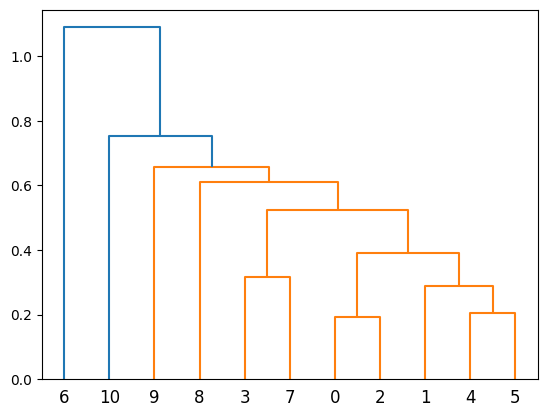

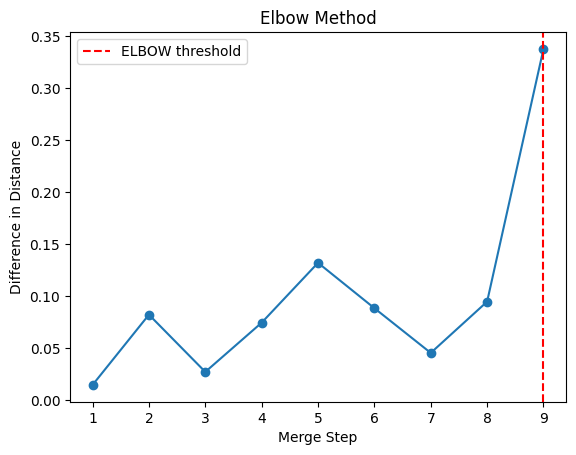

In [13]:
dn = eta_cov_tree_elbow_thresholding(eta_tensor, plot_elbow=True)

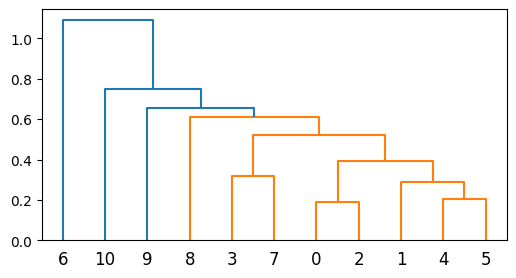

In [28]:
# THIS IS SUS. I am cutting the tree with the knowlege of 9 should be with 6
dn = eta_cov_tree(eta_tensor, thres=0.65)

In [29]:
X = sc.read_h5ad(path)
assign_clones(eta_tensor, dn, X)

/Users/mingxuanzhang/Desktop/echidna3/notebooks/../echidna/eval.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hier_colors = [color_dict.loc[int(i)][0] for i in X.obs["leiden"]]


/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


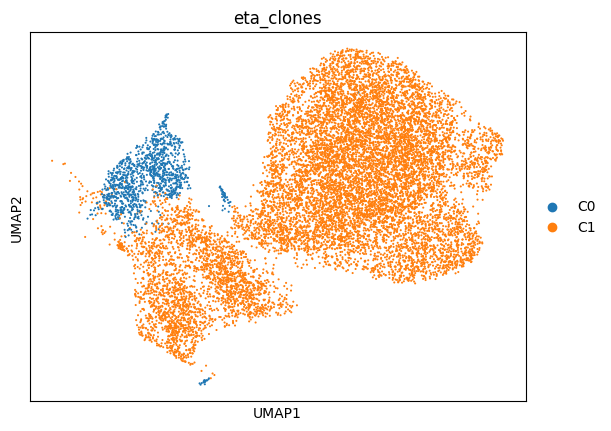

In [30]:
sc.pl.umap(X, color=['eta_clones'])

# Log likelihood ratio test

## First see if gamma fit works

In [33]:
genes = list(c_pre['genes'])
c_pre_tensor = torch.tensor(c_pre[c_pre.select_dtypes(include=[float, int]).columns].values.astype(float).T)
c_on_tensor = torch.tensor(c_on[c_on.select_dtypes(include=[float, int]).columns].values.astype(float).T)

In [37]:
c_pre_c0 = torch.mean(c_pre_tensor[[6, 10, 9], :], dim=0)
c_on_c0 = torch.mean(c_on_tensor[[6, 10, 9], :], dim=0)

In [40]:
from scipy.stats import gamma
from scipy.stats import chi2
from scipy.stats import kstest


In [44]:
# H0: c pre is the true model
params_null = gamma.fit(c_pre_c0)
# goodness of fit
ks_statistic, ks_p_value = kstest(c_pre_c0, 'gamma', args=params_null)
print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {ks_p_value}')

KS Statistic: 0.8900087366832736
P-value: 0.0


In [45]:
# H1: c on is the true model
params_alt = gamma.fit(c_on_c0)
# goodness of fit
ks_statistic, ks_p_value = kstest(c_on_c0, 'gamma', args=params_alt)
print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {ks_p_value}')

KS Statistic: 0.6864476896717575
P-value: 0.0


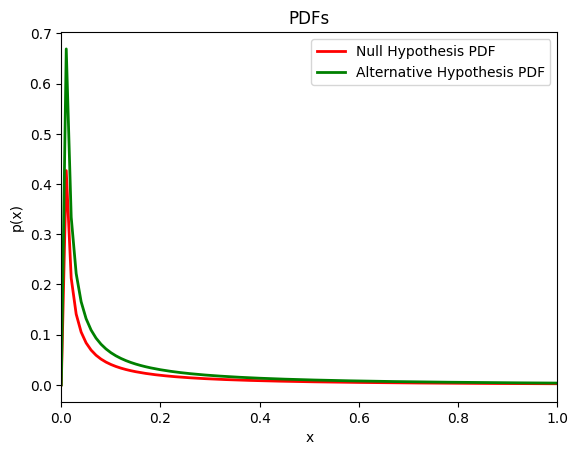

In [55]:
x = np.linspace(0, 10, 1000)
pdf_null = gamma.pdf(x, *params_null)
pdf_alt = gamma.pdf(x, *params_alt)

plt.plot(x, pdf_null, 'r-', lw=2, label='Null Hypothesis PDF')
plt.plot(x, pdf_alt, 'g-', lw=2, label='Alternative Hypothesis PDF')

# Add labels and a legend to the plot
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title("PDFs")
plt.legend()
plt.xlim(0, 1)

# Show the plot
plt.show()

## likelihood test per gene in c on vs c pre

In [92]:
from scipy.stats import chi2
from statsmodels.stats.multitest import multipletests
import tqdm

In [79]:
num_genes = eta_tensor.shape[-1]
num_genes = 500

In [80]:
c_pre_c0 = c_pre_tensor[[6, 10, 9], :num_genes].numpy().T
c_on_c0 = c_on_tensor[[6, 10, 9], :num_genes].numpy().T

In [97]:
def likelihood_ratio_test(cond1, cond2):
    params_cond1= gamma.fit(cond1)
    params_cond2 = gamma.fit(cond2)

    # Calculate log-likelihood 
    log_likelihood_cond1 = np.abs(np.sum(gamma.logpdf(cond1, *params_cond1)))
    log_likelihood_cond2 = np.abs(np.sum(gamma.logpdf(cond2, *params_cond2)))

    # Calculate likelihood ratio test statistic
    test_statistic = 2 * (log_likelihood_cond1 - log_likelihood_cond2)
    
    # Chi-squared test
    p_value = 1 - chi2.cdf(test_statistic, 2)

    return test_statistic, p_value

# Perform the likelihood ratio test for each gene
test_statistics = []
p_values = []

for i in tqdm.tqdm(range(num_genes)):
    test_statistic, p_value = likelihood_ratio_test(c_pre_c0[i], c_on_c0[i])
    test_statistics.append(test_statistic)
    p_values.append(p_value)

# Adjust p-values for multiple testing (e.g., using Benjamini-Hochberg)
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


In [98]:
res = pd.DataFrame()
res['genes'] = genes[:500]
res['test_statistics'] = test_statistics
res['p_value_adj'] = adjusted_p_values
res = res.sort_values(by='p_value_adj')
res

,genes,test_statistics,p_value_adj
21,MXRA8,123.781696,0.0
132,SLC2A5,97.268594,0.0
391,FO393419.2,99.531583,0.0
197,PDPN,114.963338,0.0
363,UBXN11,97.199437,0.0
...,...,...,...
173,ANGPTL7,-243.781982,1.0
172,MTOR-AS1,-160.165253,1.0
170,EXOSC10-AS1,-227.081364,1.0
184,MTHFR,-7.613027,1.0
